# Week 8

In [142]:
import networkx as nx
import io
import urllib
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

## Path Lengths

### Exercises

**Q1:** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this:

In [2]:
# Open file and create graph
wikispedia_graph = nx.DiGraph()
f = io.open('./week8/wikispeedia_paths-and-graph/links.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    links = line.split('\t')
    # skip all retrieved information that is not an edge
    if len(links) != 2:
        continue
    out_node = urllib.unquote(str(links[0])).decode('utf8')
    in_node = urllib.unquote(str(links[1]).replace('\n','')).decode('utf8')
    wikispedia_graph.add_edge(out_node,in_node)
    
# close the file
f.close()

In [4]:
# Find path lengths between every node
path_lengths = nx.shortest_path_length(wikispedia_graph)

In [5]:
all_path_lengths = []

# path_lengths is a dict containing another dict
# From networkx: path[source][target]=L, where L is the length of the shortest path
for node_dict in path_lengths.values():
    # add 
    all_path_lengths.extend(node_dict.values())

# create distributions, use min and max to create bins
min_length = min(all_path_lengths)
max_length = max(all_path_lengths)

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_path_lengths, bins)

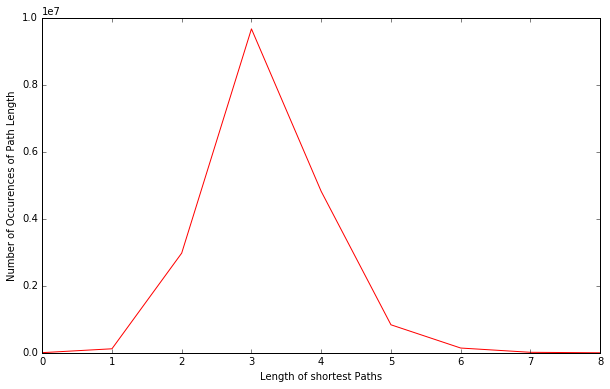

In [6]:
plt.figure(figsize=(10,6))
plt.plot(bin_edges[:-1], hist, 'r-')
plt.ylabel("Number of Occurences of Path Length")
plt.xlabel("Length of shortest Paths")
plt.show()

**Q2:** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:

In [57]:
# create list to hold all lengths
all_human_lengths = {}

# Open file
f = io.open('./week8/wikispeedia_paths-and-graph/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited
    nodes = path.split(';')
        
    source = urllib.unquote(str(nodes[0])).decode('utf8')
    target = urllib.unquote(str(nodes[-1])).decode('utf8')
    
    # if the source and target are the same the game is already over!
    if source == target:
        continue
        
    # length is equal to the total number of nodes found minus all the backspaces
    length = len(nodes) - nodes.count('<')
    
    # path[source][target] = length
    if source in all_human_lengths:
        if target in all_human_lengths[source]:
            all_human_lengths[source][target].append(length)
        else:
            all_human_lengths[source][target] = [length]
    else:
        all_human_lengths[source] = {target: [length]}
    
# close file
f.close()

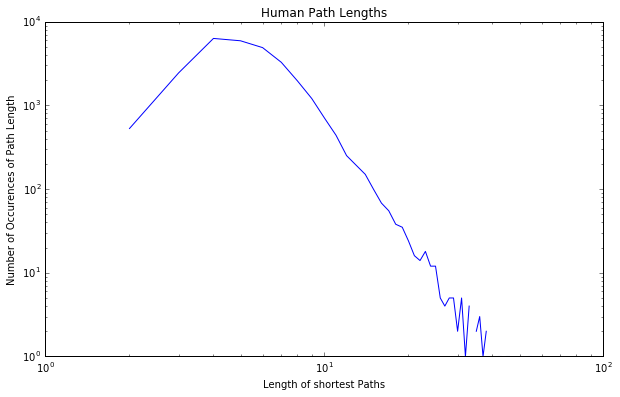

In [58]:
all_human_lengths_values = [np.average(lengths) for source, targets in all_human_lengths.iteritems() for target, lengths in targets.iteritems()]

# create distributions, use min and max to create bins
min_length = int(min(all_human_lengths_values))
max_length = int(max(all_human_lengths_values))

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_human_lengths_values, bins)

plt.figure(figsize=(10,6))
plt.loglog(bin_edges[:-1], hist, 'b-')
plt.title('Human Path Lengths')
plt.ylabel("Number of Occurences of Path Length")
plt.xlabel("Length of shortest Paths")
plt.show()

**Q3:** How much longer are the human paths on average?

In [59]:
average_path = np.average(all_path_lengths)
average_human_path = np.average(all_human_lengths_values)

print "Human paths are on average %.1f nodes longer." % (average_human_path - average_path)

Human paths are on average 2.8 nodes longer.


Create scatter plot where each point is a source/target pair, and you have human path lengths on the xx-axis and shortests paths on the yy-axis.

In [60]:
x = []
y = []

for human_source, human_targets in all_human_lengths.iteritems():

    # skip if source is not found in path_lengths dict
    if human_source not in path_lengths:
        continue
            
    for human_target, human_lengths in human_targets.iteritems():
        
        # skip if target is not found in path_lengths dict
        if human_target not in path_lengths[human_source]:
            continue
        
        # take human length to be the average of all the path lengths
        human_length = int(np.average(human_lengths))
        # add human path length
        x.append(human_length)
        
        # retrieve path length using human node and target
        path_length = path_lengths[human_source][human_target]
        # add path length
        y.append(path_length)

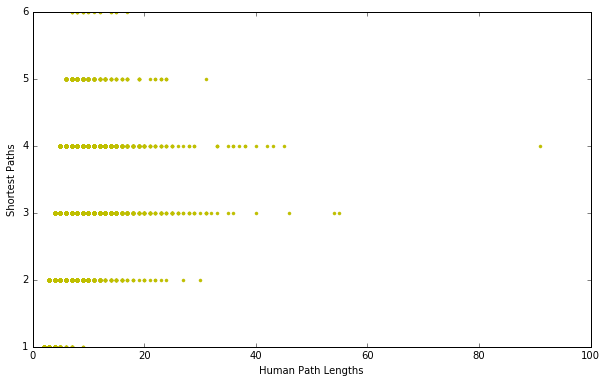

In [62]:
plt.figure(figsize=(10,6))
plt.plot(x, y, 'y.')
plt.ylabel("Shortest Paths")
plt.xlabel("Human Path Lengths")
plt.show()

Is there a correlation between human/shortest path-lengths? What is the correlation.

> ????

## Betweenness

### Exercises

Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.

In [66]:
# watch this take 2 hours
betweenness_centrality = nx.betweenness_centrality(wikispedia_graph)

In [70]:
# init dictionary to have all nodes and value = 0
navigation_centrality = dict.fromkeys(wikispedia_graph.nodes(),0.)

# find all lists that 
all_path_lists = nx.shortest_path(wikispedia_graph)
total_paths = 0.

for source, targets in all_path_lists.iteritems():
    for target, path in targets.iteritems():
        total_paths += 1.
        for node in path[1:-1]:
            navigation_centrality[node] += 1.
            
for node, value in navigation_centrality.iteritems():
    navigation_centrality[node] = value / total_paths

First, list the 5 pages with highest navigation centrality.

In [79]:
# sort navigation centrality
navigation_centrality_sorted = sorted(navigation_centrality.iteritems(), key=lambda (k,v): -v)

print navigation_centrality_sorted[:5]

[(u'United_States', 0.09799052096913277), (u'United_Kingdom', 0.05439199166517371), (u'Europe', 0.036134683968749456), (u'England', 0.031888154298627715), (u'Canada', 0.02244618072914025)]


Second, list the 5 pages with highest betweenness centrality.

In [78]:
# sort betweenness centrality
betweenness_centrality_sorted = sorted(betweenness_centrality.iteritems(), key=lambda (k,v): -v)

print betweenness_centrality_sorted[:5]

[(u'United_States', 0.0940496613023829), (u'United_Kingdom', 0.04236933026802466), (u'England', 0.032388897205766494), (u'Europe', 0.026979909689289164), (u'Africa', 0.02419330332525558)]


Compare the two lists. Explain the differences between the two lists in your own words.

> I don't have any words

Create a scatterplot of betweenness centrality vs. navigation centrality.

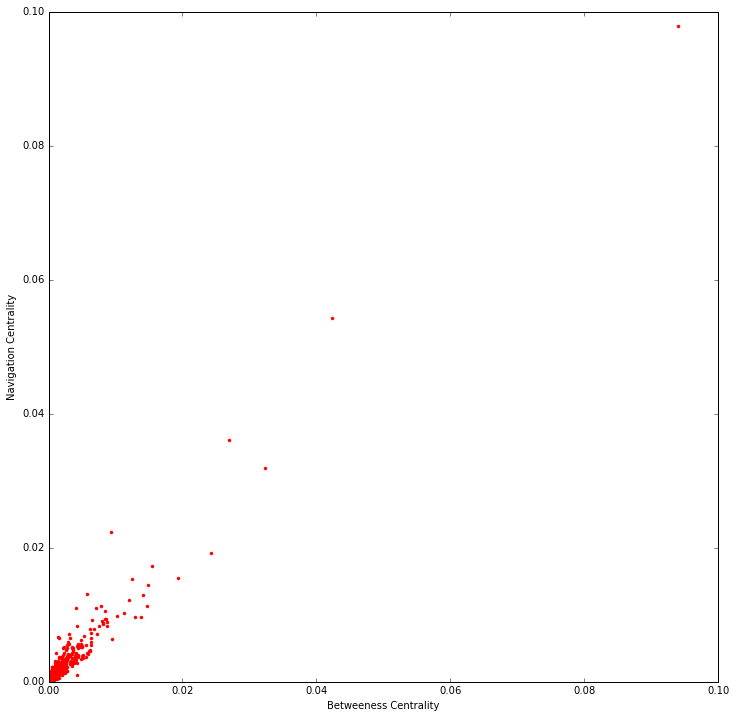

In [126]:
btw_values = []
nav_values = []

for node, btw in betweenness_centrality.iteritems():
    btw_values.append(btw)
    
    # use node to get corresponding navigation centrality value
    nav = navigation_centrality[node]
    nav_values.append(nav)


plt.figure(figsize=(12,12))
plt.plot(btw_values, nav_values, 'r.')
plt.ylabel("Navigation Centrality")
plt.xlabel("Betweeness Centrality")
plt.show()

How many pages have zero navigation centrality

In [116]:
zero_navigation = [node for node, value in navigation_centrality.iteritems() if value == 0]

print "%s nodes have zero navigation centrality." % len(zero_navigation)

570 nodes have zero navigation centrality.


What is the the page with zero navigation centrality and highest betweenness centrality? 

In [117]:
max_centrality = ('',0)
for node in zero_navigation:
    value = betweenness_centrality[node]
    if value > max_centrality[1]:
        max_centrality = (node, value)
        
print max_centrality

(u'Brabantian', 9.180048774365921e-06)


Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).

> ????

Plot the distribution of betweenness centrality for the pages with zero navigation centrality.

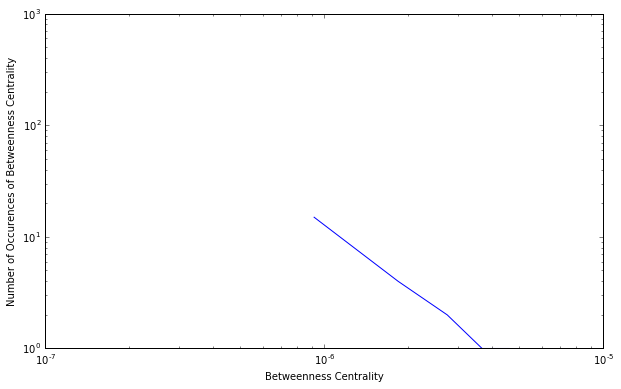

In [120]:
hist, bin_edges = np.histogram([value for node, value in betweenness_centrality.iteritems() if node in zero_navigation])

plt.figure(figsize=(10,6))
plt.loglog(bin_edges[:-1], hist, 'b-')
plt.ylabel("Number of Occurences of Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.show()

What is the correlation between betweenness centrality and navigation centrality?

> ???

Comment on the top 5 outliers.

> ???

## Bringing the text into the picture

### Exercises

First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now characterize each page by a TF-IDF vector and not a group of pages.

In [132]:
def tokenizer(raw):
    
    # get tokens from raw text
    tokens = nltk.word_tokenize(raw)
    
    # retrieve common stop words form nltk
    stopwords = nltk.corpus.stopwords.words('english')
    
    # isalpha returns true when no special characters and numbers are in a string
    # create stemmed list of tokens not found in remove words or when isaplha is not satisfied
    return [t.lower() for t in set(tokens) if t.lower() not in stopwords and t.isalpha()]

In [160]:
directory = './week8/plaintext_articles'
tokens = {}

for filename in os.listdir(directory):
    f = io.open(directory + '/' + filename, encoding='utf-8')
    raw = f.read()
    name = urllib.unquote(str(filename.replace('.txt',''))).decode('utf8')
    tokens[name] = tokenizer(raw)
    f.close()

In [161]:
names = [name for name in tokens]

tf = {}

for name, words in tokens.iteritems():
    fd = nltk.FreqDist(words)
    tf[name] = fd

In [162]:
all_words = []
for name, words in tokens.iteritems():
    all_words.extend(set(words))
    
unique_words = set(all_words)

occurences = dict.fromkeys(unique_words,0.)
# total number of files
N = len(tokens.keys()) 

for word in all_words:
    occurences[word] += 1.
    
idf = {}
for word, occurence in occurences.iteritems():
    idf[word] = math.log(N / occurence,10)

In [172]:
tf_idf = dict.fromkeys(names, {})

for name, fd in tf.iteritems():
    for word, count in fd.iteritems():
        tf_idf[name][word] = count * idf[word]

In [173]:
def cosine_similarity(A,B):
    dot = 0.
    for word, value in A.iteritems():
        if word in B:
            dot += value * B[word]
    
    return dot / (np.linalg.norm(A.values()) * np.linalg.norm(B.values()))

Calculate the average similarity for all human navigation paths (the source/target pairs from above). Calculate mean/variance of these average similarities.

In [ ]:
similarities = {}

f = io.open('./week8/wikispeedia_paths-and-graph/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited
    nodes = path.split(';')
        
    source = urllib.unquote(str(nodes[0])).decode('utf8')
    target = urllib.unquote(str(nodes[-1])).decode('utf8')
    
    cos_sim = cosine_similarity(tf_idf[source], tf_idf[target])
    
    # create key using source and target
    if source in similarities:
        if target in similarities[source]:
            similarities[source][target].append(cos_sim)
        else:
            similarities[source][target] = [cos_sim]
    else:
        similarities[source] = {target: [cos_sim]}
    
# close file
f.close()